# Approach 3 - Local Features
For this approach, we extract local features from the Lapse images using SIFT and cluster them into a vocabulary (Bag of Words approach). Using this vocabulary, we can map every Lapse and Motion image to a BoW feature vector. The Lapse feature vectors make up the training data for a one-class SVM. The decision boundary of the SVM can then be customized to achieve the right compromise between correct keeps and correct eliminations.
As we are using SIFT descriptors, we work on grayscale images.

## Advantages
- scale, rotation and position invariance = invariance to camera movements
- not sensitive to lighting changes


## Disadvantages
- no color information
- Instead of detecting the anomalies (animals), we detect the absence of a sufficiently large portion of the background. Smaller objects are therefore especially hard to detect.

In [1]:
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

from py.PlotUtils import plot_roc_curve, get_percentiles
from py.Dataset import Dataset
from py.ImageUtils import display_images

DIR = '/home/kleinsteuber/vscode/ResizedSessions_NoBackup' # dataset directory

ds = Dataset(DIR)
session = ds.create_session("beaver_01")

Found 3 sessions
Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


## Compute SIFT descriptors
Since there are often thousands of SIFT keypoints, we limit the number of keypoints to 400. To select larger keypoints (i.e. in higher octaves), we choose a larger sigma of 2.4 (default: 1.6).

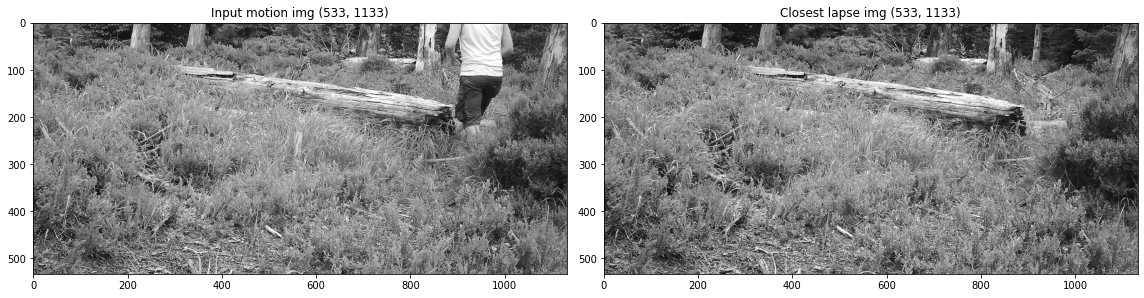

In [2]:
# Get motion image and closest lapse image for comparison
motion_img = session.get_random_motion_image(day_only=True)
before_img, after_img, rel = motion_img.get_closest_lapse_images()
closest_img = before_img if rel <= 0.5 else after_img

# read and display images
img = motion_img.read_opencv(gray=True)
comp_img = closest_img.read_opencv(gray=True)
display_images([img, comp_img], [f"Input motion img {img.shape}", f"Closest lapse img {comp_img.shape}"], cmap="gray")

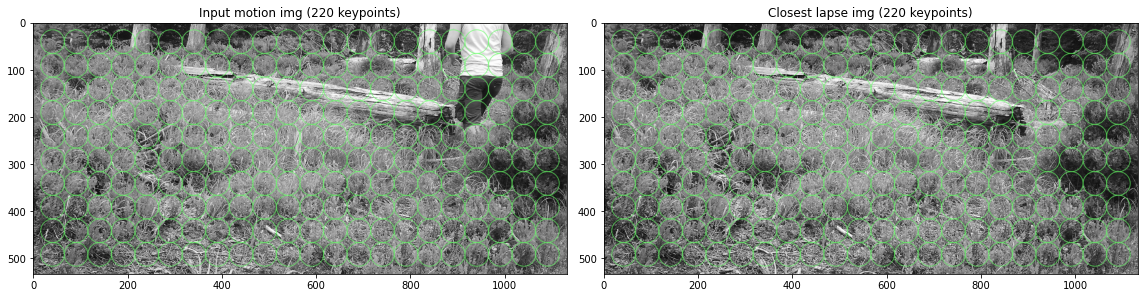

In [7]:
def dense_keypoints(img, step=50, size=50):
    # calculate offset to center keypoints
    off = ((img.shape[0] % step) // 2, (img.shape[1] % step) // 2)
    border_dist = (step + 1) // 2
    return [cv.KeyPoint(x, y, size) for y in range(border_dist + off[0], img.shape[0] - border_dist, step) 
                                    for x in range(border_dist + off[1], img.shape[1] - border_dist, step)]

sift = cv.SIFT_create()

img_kp = dense_keypoints(img)
img_kp, img_des = sift.compute(img, img_kp)

comp_img_kp = dense_keypoints(comp_img)
comp_img_kp, comp_img_des = sift.compute(comp_img, comp_img_kp)

kp_img = cv.drawKeypoints(img, img_kp, img, (100, 255, 100), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
comp_kp_img = cv.drawKeypoints(comp_img, comp_img_kp, comp_img, (100, 255, 100), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

display_images([kp_img, comp_kp_img], [f"Input motion img ({len(img_kp)} keypoints)", f"Closest lapse img ({len(comp_img_kp)} keypoints)"])

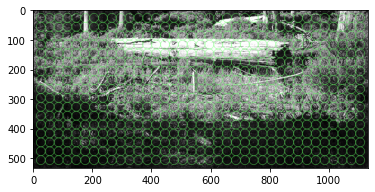

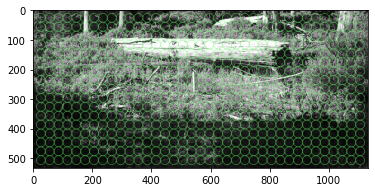

In [15]:
# Save raw images
plt.figure(figsize=(6,4))
plt.imshow(kp_img)
plt.savefig("approach3_keypoints.pdf", bbox_inches="tight")
plt.show()

plt.figure(figsize=(6,4))
plt.imshow(comp_kp_img)
plt.savefig("approach3_keypoints_lapse.pdf", bbox_inches="tight")
plt.show()

## Matching keypoints
We match SIFT descriptors against each other using a BF (brute-force) matcher. In the following, we match the keypoints of the lapse and motion image for testing purposes.

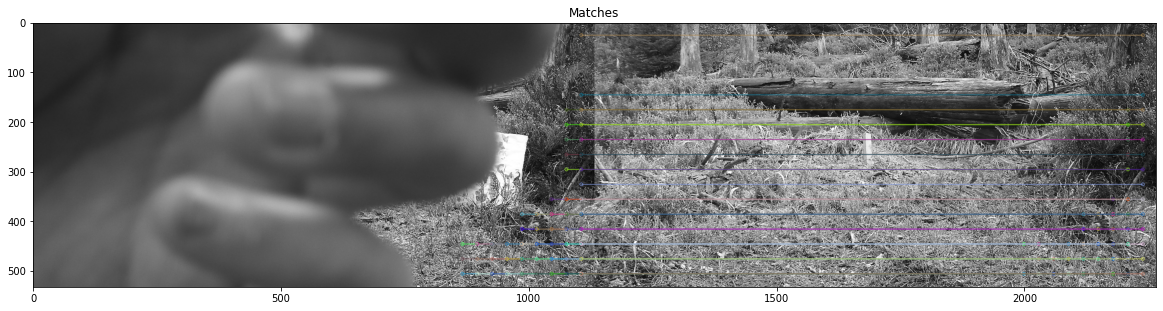

In [4]:
bf = cv.BFMatcher()
# Match descriptors, calculate best two matches
matches = bf.knnMatch(img_des, comp_img_des, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv.drawMatchesKnn expects list of lists as matches.
matches_img = cv.drawMatchesKnn(img, img_kp, comp_img, comp_img_kp, good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
display_images([matches_img], ["Matches"], size=(16,5))

## Evaluation

The test data must be labeled (normal/anomalous).

In [2]:
# test labels
from py.Labels import LABELS

clusters = 1024 # BOW vocabulary size
step = 30 # DSIFT keypoint step size
size = 30 # DSIFT keypoint size
suffix = "_random" # "_motion" if motion keypoints were included in clustering, "_random" if random clustering was used instead of kmeans
test_labels = []
test_df = []
with open(f"./bow_train_NoBackup/{session.name}/bow_eval_{step}_{size}_{clusters}{suffix}.csv", "r") as f:
    for line in f:
        entries = line.split(",")
        filename = entries[0]
        img_number = int(filename[-9:-4])
        if img_number > LABELS[session.name]["max"] or img_number in LABELS[session.name]["not_annotated"]:
            continue
        is_normal = (img_number in LABELS[session.name]["normal"])
        test_labels.append(1 if is_normal else -1)
        test_df.append([float(df) for df in entries[1:]])
test_labels = np.array(test_labels)
test_df = np.array(test_df)
print(f"{len(test_df)} test results with {len(test_labels)} labels")

695 test results with 695 labels


In [4]:
def eval_test(test_labels, test_df, df_threshold = 0):
    test_results = np.where(test_df >= df_threshold, np.ones(test_df.shape[0]), -np.ones(test_df.shape[0]))

    accuracy = np.mean(test_results == test_labels)
    tar = np.sum((test_results == 1) & (test_labels == 1)) / np.sum(test_labels == 1)
    tnr = np.sum((test_results == -1) & (test_labels == -1)) / np.sum(test_labels == -1)
    far = np.sum((test_results == 1) & (test_labels == -1)) / np.sum(test_labels == -1)
    fnr = np.sum((test_results == -1) & (test_labels == 1)) / np.sum(test_labels == 1)
    precision = (np.sum((test_results == 1) & (test_labels == 1)) / np.sum(test_results == 1)) if np.any(test_results == 1) else 0

    return accuracy, tar, tnr, far, fnr, precision

accuracy, tar, tnr, far, fnr, precision = eval_test(test_labels, test_df[:,0])

labeled_normal = np.mean(test_labels == 1)
print(f"{labeled_normal:.3f} labeled normal, {(1 - labeled_normal):.3f} anomalous")

print(f"Accuracy:                               {accuracy:.3f}")
print(f"True anomalous rate (must be high!):    {tar:.3f} \t - How many animals are detected as animals? (recall)")
print(f"True normal rate (higher is better):    {tnr:.3f} \t - How many empties are detected as empties?")
print(f"False anomalous rate (lower is better): {far:.3f} \t - How many empties are detected as animals?")
print(f"False normal rate (must be low!):       {fnr:.3f} \t - How many animals are detected as empties?")
print(f"Precision (higher is better):           {precision:.3f} \t - How many detected animals are actually animals?")

0.106 labeled normal, 0.894 anomalous
Accuracy:                               0.812
True anomalous rate (must be high!):    0.459 	 - How many animals are detected as animals? (recall)
True normal rate (higher is better):    0.853 	 - How many empties are detected as empties?
False anomalous rate (lower is better): 0.147 	 - How many empties are detected as animals?
False normal rate (must be low!):       0.541 	 - How many animals are detected as empties?
Precision (higher is better):           0.272 	 - How many detected animals are actually animals?


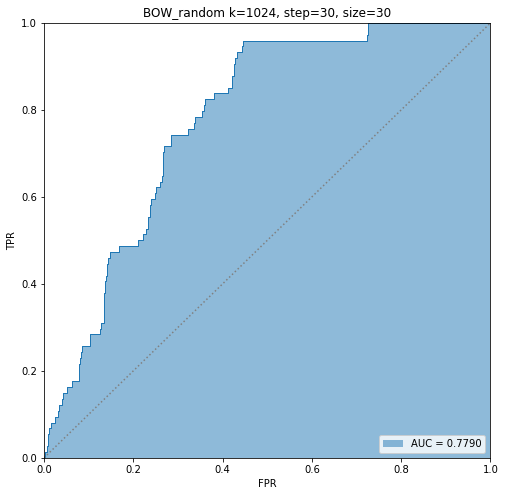

0.9 percentile : TPR = 0.9054, FPR = 0.4251 <-> TNR = 0.5749 @ thresh -57.98641920691854
0.95 percentile : TPR = 0.9595, FPR = 0.4461 <-> TNR = 0.5539 @ thresh -61.21968592548046
0.98 percentile : TPR = 1.0000, FPR = 0.7246 <-> TNR = 0.2754 @ thresh -86.32043784641692
0.99 percentile : TPR = 1.0000, FPR = 0.7246 <-> TNR = 0.2754 @ thresh -86.32043784641692


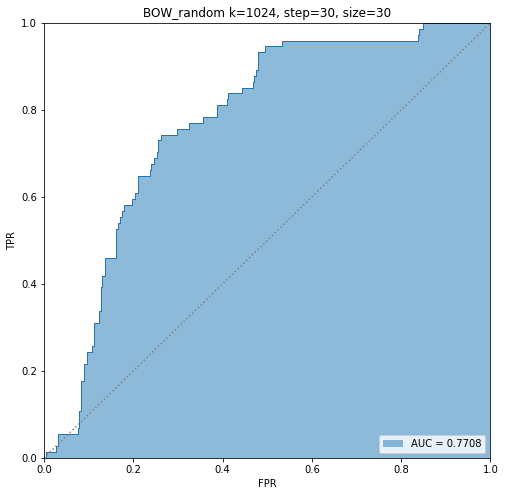

0.9 percentile : TPR = 0.9324, FPR = 0.4783 <-> TNR = 0.5217 @ thresh -57.96909824319087
0.95 percentile : TPR = 0.9595, FPR = 0.5330 <-> TNR = 0.4670 @ thresh -62.89029834951606
0.98 percentile : TPR = 0.9865, FPR = 0.8406 <-> TNR = 0.1594 @ thresh -98.31221120460783
0.99 percentile : TPR = 1.0000, FPR = 0.8486 <-> TNR = 0.1514 @ thresh -99.81392414777008


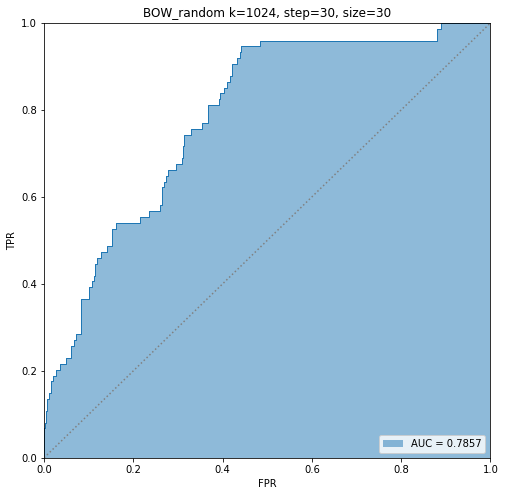

0.9 percentile : TPR = 0.9054, FPR = 0.4203 <-> TNR = 0.5797 @ thresh -46.42222143397851
0.95 percentile : TPR = 0.9595, FPR = 0.4831 <-> TNR = 0.5169 @ thresh -57.77152350231944
0.98 percentile : TPR = 0.9865, FPR = 0.8792 <-> TNR = 0.1208 @ thresh -115.37954689562615
0.99 percentile : TPR = 1.0000, FPR = 0.8889 <-> TNR = 0.1111 @ thresh -116.92268156510316


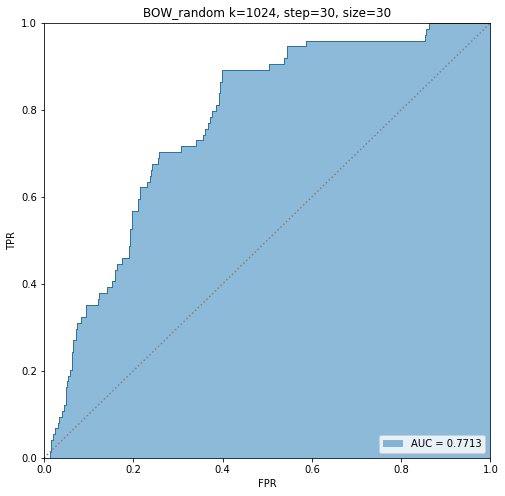

0.9 percentile : TPR = 0.9054, FPR = 0.5040 <-> TNR = 0.4960 @ thresh -61.930335188957514
0.95 percentile : TPR = 0.9595, FPR = 0.5862 <-> TNR = 0.4138 @ thresh -69.43002627253318
0.98 percentile : TPR = 0.9865, FPR = 0.8567 <-> TNR = 0.1433 @ thresh -105.25911261294101
0.99 percentile : TPR = 1.0000, FPR = 0.8631 <-> TNR = 0.1369 @ thresh -106.31607699933667


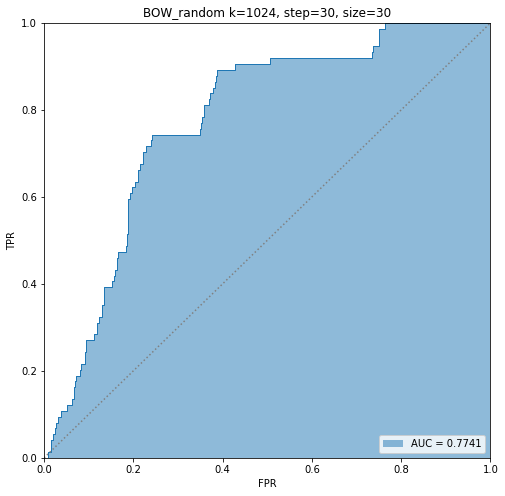

0.9 percentile : TPR = 0.9054, FPR = 0.4267 <-> TNR = 0.5733 @ thresh -53.909889538817794
0.95 percentile : TPR = 0.9865, FPR = 0.7504 <-> TNR = 0.2496 @ thresh -90.7365004449735
0.98 percentile : TPR = 0.9865, FPR = 0.7504 <-> TNR = 0.2496 @ thresh -90.7365004449735
0.99 percentile : TPR = 1.0000, FPR = 0.7633 <-> TNR = 0.2367 @ thresh -93.59593916928242


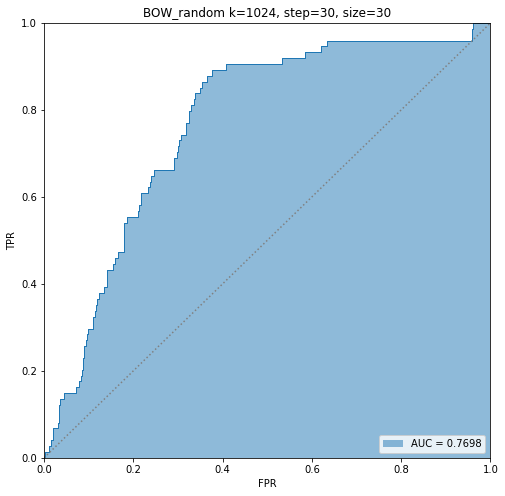

0.9 percentile : TPR = 0.9054, FPR = 0.4074 <-> TNR = 0.5926 @ thresh -50.9529406696179
0.95 percentile : TPR = 0.9595, FPR = 0.6329 <-> TNR = 0.3671 @ thresh -70.21557341362325
0.98 percentile : TPR = 0.9865, FPR = 0.9581 <-> TNR = 0.0419 @ thresh -134.91997546198
0.99 percentile : TPR = 1.0000, FPR = 0.9597 <-> TNR = 0.0403 @ thresh -135.2997479443061


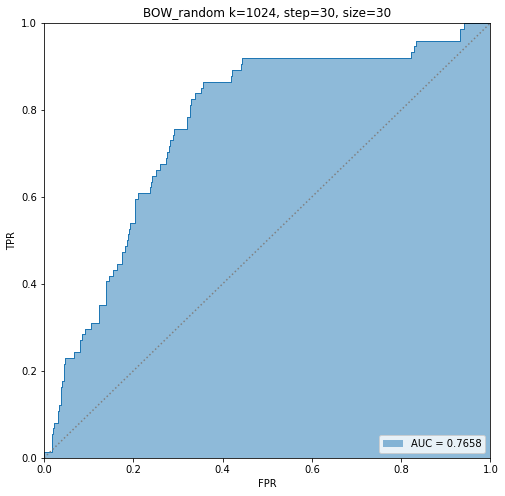

0.9 percentile : TPR = 0.9054, FPR = 0.4412 <-> TNR = 0.5588 @ thresh -59.7249890637227
0.95 percentile : TPR = 0.9595, FPR = 0.8325 <-> TNR = 0.1675 @ thresh -104.88935442840156
0.98 percentile : TPR = 0.9865, FPR = 0.9308 <-> TNR = 0.0692 @ thresh -125.43362546843687
0.99 percentile : TPR = 1.0000, FPR = 0.9404 <-> TNR = 0.0596 @ thresh -127.38773813743325


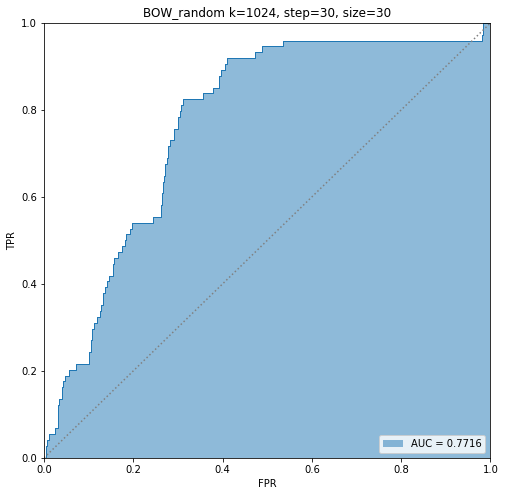

0.9 percentile : TPR = 0.9054, FPR = 0.4058 <-> TNR = 0.5942 @ thresh -46.53070784749596
0.95 percentile : TPR = 0.9595, FPR = 0.5362 <-> TNR = 0.4638 @ thresh -64.09642838226235
0.98 percentile : TPR = 0.9865, FPR = 0.9823 <-> TNR = 0.0177 @ thresh -141.45833482134157
0.99 percentile : TPR = 1.0000, FPR = 0.9839 <-> TNR = 0.0161 @ thresh -143.72105353295728


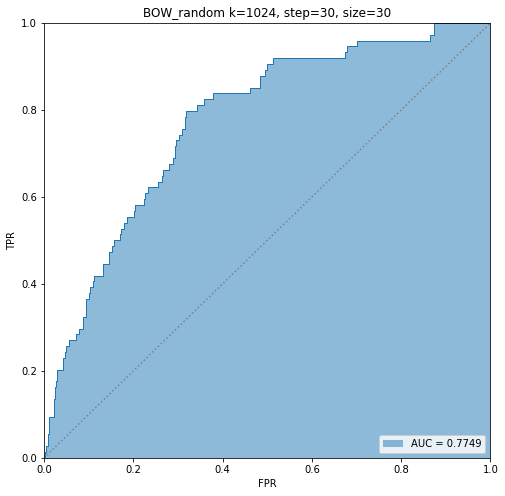

0.9 percentile : TPR = 0.9054, FPR = 0.4992 <-> TNR = 0.5008 @ thresh -55.06037151525953
0.95 percentile : TPR = 0.9595, FPR = 0.7021 <-> TNR = 0.2979 @ thresh -69.55509817226138
0.98 percentile : TPR = 1.0000, FPR = 0.8728 <-> TNR = 0.1272 @ thresh -97.60153074288088
0.99 percentile : TPR = 1.0000, FPR = 0.8728 <-> TNR = 0.1272 @ thresh -97.60153074288088


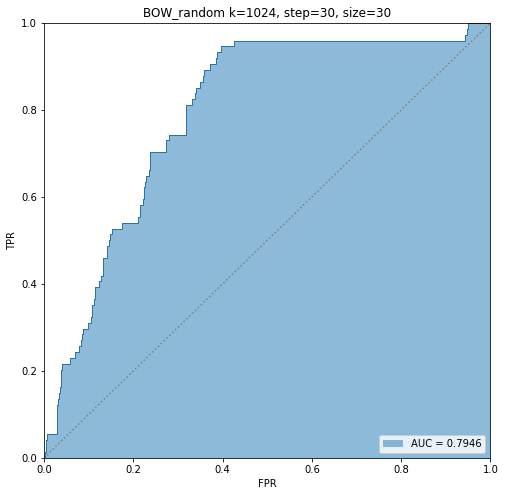

0.9 percentile : TPR = 0.9054, FPR = 0.3720 <-> TNR = 0.6280 @ thresh -49.69415716064934
0.95 percentile : TPR = 0.9595, FPR = 0.4251 <-> TNR = 0.5749 @ thresh -59.1537640092654
0.98 percentile : TPR = 0.9865, FPR = 0.9469 <-> TNR = 0.0531 @ thresh -135.67460585387744
0.99 percentile : TPR = 1.0000, FPR = 0.9501 <-> TNR = 0.0499 @ thresh -135.8753471614021
AUC avg = 0.7758 2*std = 0.0163 min = 0.7658 max = 0.7946
TNR for TPR >= .9  avg = 0.5620 2*std = 0.0817 min = 0.4960 max = 0.6280
TNR for TPR >= .95 avg = 0.4072 2*std = 0.2564 min = 0.1675 max = 0.5749
TNR for TPR >= .98 avg = 0.1258 2*std = 0.1629 min = 0.0177 max = 0.2754
TNR for TPR >= .99 avg = 0.1205 2*std = 0.1611 min = 0.0161 max = 0.2754


In [12]:
aucs = []
percentiles = []
for i in range(test_df.shape[1]):
    fpr, tpr, thresholds, auc_score = plot_roc_curve(test_labels, test_df[:,i], f"BOW{suffix} k={clusters}, step={step}, size={size}")
    #savefile=f"plots/approach3/roc_curves/{session.name}_{step}_{size}_{clusters}{suffix}"
    tnrs = get_percentiles(fpr, tpr, thresholds)
    aucs.append(auc_score)
    percentiles.append(tnrs)
percentiles = np.array(percentiles)
print(f"AUC avg = {np.mean(aucs):.4f} 2*std = {2*np.std(aucs):.4f} min = {np.min(aucs):.4f} max = {np.max(aucs):.4f}")
for i, tpr in enumerate([".9 ", ".95", ".98", ".99"]):
    print(f"TNR for TPR >= {tpr} avg = {np.mean(percentiles[:,i]):.4f} 2*std = {2*np.std(percentiles[:,i]):.4f} min = {np.min(percentiles[:,i]):.4f} max = {np.max(percentiles[:,i]):.4f}")

## AUC Scores

### Beaver_01

| $k$ (clusters) | $kp$ (keypoint step size) | AUC |
| --- | --- | ---: |
| 512 | 30 | 0.7538 |
| 1024 | 30 | 0.7698 |
| 2048 | 30 | 0.7741 |
| 1024 | 20 | 0.7406 |
| 1024 | 30, size 60 | 0.7383 |

### Marten_01

| $k$ (clusters) | $kp$ (keypoint step size) | AUC |
| --- | --- | ---: |
| 512 | 30 | 0.7079 |
| 1024 | 30 | 0.7099 |
| 2048 | 30 | 0.6557 |